# Automation Notebook For Land Ownership Ribbons - Absorka Front
### Refrences: 
* https://pro.arcgis.com/en/pro-app/latest/arcpy/main/arcgis-pro-arcpy-reference.htm
* Created by Izak Boardman | Research Assistant InfoGraphics Lab
* Contact: Izak.Boardman@gmail.com 

In [ ]:
import matplotlib.pyplot as plt # Plotting
import arcpy # GIS Analysis
import os
import tempfile

### Temp Directory Creation 
* Temp Dir be bypassed inside of classify_line() with any directory path within the project

In [ ]:
def make_temp_dir():
    """
    Make temporary directory in ArcPro current project for storing temp routes and data.
    Temp Dir Usage 
    """
    # Get the current working directory
    curr_path = os.getcwd()
    print(f"Current Path: {curr_path}")

    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()
    print(f"Temporary directory created at: {temp_dir}")

    # Check if the directory exists
    if os.path.isdir(temp_dir):
        print(f"Directory '{temp_dir}' exists")
    else:
        print(f"Directory '{temp_dir}' does not exist")

    return temp_dir

## `classify_line` Function Usage
- Pass either:
  - A map layer name, or  
  - A path to multiple layers (layers must be **polyline shapefiles**)  
- Returns a **Route Classification Dictionary** with an **Elevation Profile Dictionary**  
  - *(Note: Elevation Profile currently not working — all elevation code is commented out)*  

#### Returned Dictionary Schema:
```python
{
    "Name": input_name,
    "Route_Classification": [
        {
            "Field": "BLM",              # Land ownership class
            "Length": 3.42,              # Length of continuous segment (miles)
            "Route_Index": 0             # Sequential index along route
        },
        ...
    ],
    "Elevation_Data": {}                 # Currently empty (stubbed out)
}

```
## Data Notes
### Padus Simple land layer contains fields:
* BLM, FED_OTHER, FWS, LOCAL, NGO, PRIVATE, USFS, PRIVATE_NGO, STATE, TRIB
* BOR is omitted (conflicts with BLM land)
* Point routes are converted to lines using geoprocessing tools

### Required fields when creating a route layer:

* FID → field ID number corresponding to the classified field (initialize as 0)
* Shape → polyline geometry
* ID → named ID of the route (e.g., gps01_fa21)


# Example Usage 
``` Python 



In [ ]:
def classify_line(path: str = None, layer_name: str = None) -> dict:
    """
    Creates a route from an input line, locates land parcels along it using linear referencing,
    and returns a dictionary of classified line lengths sorted by Route ID and FMEAS,
    along with elevation (Z) values and distances (M).
    """

    # Input PADUS land ownership data (note: BOR omitted to avoid overlap with BLM)
    land_layer = r"\\cas-fs-geog\InfoGraphics\Projects\Absaroka Front\OwnershipRibbons\Pro\OwnershipRibbonsAutomate\OwnershipRibbonsAutomate.gdb\PadusDataLayer_NoBOR"
    
    print("Initializing classification workflow...")

    # Create a temporary directory + geodatabase for intermediate outputs
    temp_dir = tempfile.mkdtemp()
    temp_gdb = os.path.join(temp_dir, "temp_outputs.gdb")
    arcpy.management.CreateFileGDB(temp_dir, "temp_outputs.gdb")
    print(f"Temporary GDB created at: {temp_gdb}")

    # --- INPUT HANDLING ---
    if path:  # User passed a direct path to feature class
        input_line = path
        input_name = os.path.splitext(os.path.basename(path))[0]
    elif layer_name:  # User passed a layer name from ArcGIS Pro
        aprx = arcpy.mp.ArcGISProject("CURRENT")
        map_obj = aprx.listMaps()[3]  # TODO: hardcoded index → consider making configurable
        print(f"Finding route from Map: {map_obj.name}")

        # Look up the target layer
        layers = [lyr for lyr in map_obj.listLayers() if lyr.name == layer_name]
        if not layers:
            raise ValueError(f"Layer '{layer_name}' not found in current map.")
        input_line = layers[0]
        input_name = layer_name
    else:
        raise ValueError("You must provide either a feature class path or a layer name.")

    # Define outputs for route creation + land location results
    route_output = os.path.join(temp_gdb, f"{input_name}_Route_temp")
    locate_output = os.path.join(temp_gdb, f"{input_name}_Located_temp")

    # --- ROUTE CREATION ---
    print("Creating route with M-values...")
    arcpy.lr.CreateRoutes(
        in_line_features=input_line,
        route_id_field="ID",   # ID field is mandatory on input
        out_feature_class=route_output,
        measure_source="LENGTH",
        coordinate_priority="LOWER_LEFT"
    )

    # Elevation data stub (kept for forward compatibility)
    elevation_dict = {}
    # Elevation code exists but is commented out due to service restrictions

    # Ensure route has an ID field (if not, create one)
    route_id_field = "ID"
    if route_id_field not in [f.name for f in arcpy.ListFields(route_output)]:
        arcpy.management.AddField(route_output, route_id_field, "TEXT")

    # Populate ID values if missing
    with arcpy.da.UpdateCursor(route_output, ["ID", route_id_field]) as cursor:
        for row in cursor:
            row[1] = f"route_{row[0]}"
            cursor.updateRow(row)

    # --- LOCATE LAND SEGMENTS ---
    print("Locating features along the created route...")
    arcpy.lr.LocateFeaturesAlongRoutes(
        in_features=land_layer,
        in_routes=route_output,
        route_id_field="ID",
        radius_or_tolerance="10 Meters",  # Buffer to account for small misalignments
        out_table=locate_output,
        out_event_properties="ID LINE FMEAS TMEAS",
        route_locations="FIRST",
        distance_field="DISTANCE",
        zero_length_events="ZERO",
        in_fields="FIELDS",
        m_direction_offsetting="M_DIRECTON"  # NOTE: typo? should confirm
    )

    # Dictionary to hold results
    route_dict = {"Route_Classification": []}

    # Extract classification fields
    fields = ["ManagerSimple", "FMEAS", "TMEAS"]
    segments = []

    with arcpy.da.SearchCursor(locate_output, fields) as cursor:
        for row in cursor:
            ManagerSimple, fmeas, tmeas = row
            land_class = ManagerSimple.strip()
            segment_length_miles = (tmeas - fmeas) * 0.00062137  # meters → miles

            segments.append({
                "FMEAS": fmeas,
                "Land_Class": land_class,
                "Segment_Length_Miles": segment_length_miles
            })
            print(segment_length_miles)

    # Sort route segments in order of traversal (low → high FMEAS)
    sorted_segments = sorted(segments, key=lambda seg: seg["FMEAS"])

    # --- MERGE SMALL SEGMENTS ---
    last_field = None
    accum_length = 0.0
    route_index = 0
    seg_tol = 0.05  # Minimum segment length (miles) below which segments are absorbed

    for segment in sorted_segments:
        current_field = segment["Land_Class"]
        current_length = segment["Segment_Length_Miles"]

        if current_field == last_field:
            # Same land class → accumulate
            accum_length += current_length
        elif current_length < seg_tol:
            # Too small → absorb into previous
            print(f"Omitting segment < {seg_tol} mi (absorbed): {current_field}")
            accum_length += current_length
        else:
            # Store previous accumulated segment before switching
            if last_field is not None:
                route_dict["Route_Classification"].append({
                    "Field": last_field,
                    "Length": accum_length,
                    "Route_Index": route_index
                })
                route_index += 1
            # Reset accumulator for new field
            last_field = current_field
            accum_length = current_length

    # Append the final accumulated segment
    if last_field is not None:
        route_dict["Route_Classification"].append({
            "Field": last_field,
            "Length": accum_length,
            "Route_Index": route_index
        })

    # --- CLEANUP TEMP FILES ---
    arcpy.management.Delete(temp_gdb)
    os.rmdir(temp_dir)
    print(f"Temporary GDB and directory deleted.")

    # --- RETURN RESULTS ---
    return {
        "Name": input_name,
        "Route_Classification": route_dict["Route_Classification"],
        "Elevation_Data": elevation_dict  # Currently empty
    }


### classify_line Workflow Diagram

```text
+--------------------------+
|  User Input              |
|  (path OR layer_name)    |
+------------+-------------+
             |
             v
+--------------------------+
|  Validate Input          |
|  - If path → use file    |
|  - If layer_name → find  |
|    in ArcGIS project     |
+------------+-------------+
             |
             v
+--------------------------+
|  Temp Workspace Setup    |
|  - Create temp dir       |
|  - Create temp .gdb      |
+------------+-------------+
             |
             v
+--------------------------+
|  Route Creation          |
|  - CreateRoutes()        |
|  - Assign M-values       |
|  - Ensure ID field       |
+------------+-------------+
             |
             v
+--------------------------+
|  Locate Land Features    |
|  - LocateFeaturesAlong   |
|    Routes()              |
|  - Output temp table     |
+------------+-------------+
             |
             v
+--------------------------+
|  Segment Processing      |
|  - Extract fields        |
|    (ManagerSimple, FMEAS,|
|     TMEAS)               |
|  - Compute length miles  |
|  - Sort by FMEAS         |
+------------+-------------+
             |
             v
+--------------------------+
|  Segment Aggregation     |
|  - Merge adjacent same   |
|    land classes          |
|  - Absorb small segments |
|    (< seg_tol miles)     |
+------------+-------------+
             |
             v
+--------------------------+
|  Build Output Dict       |
|  {                      |
|    "Name": ...,         |
|    "Route_Classification":|
|       [ {Field, Length,  |
|           Route_Index} ],|
|    "Elevation_Data": {} |
|  }                      |
+------------+-------------+
             |
             v
+--------------------------+
|  Cleanup                 |
|  - Delete temp gdb       |
|  - Delete temp dir       |
+--------------------------+
```
### Returns ->
```Python 
{'Name': 'gps50_fa21_Simple',
 'Route_Classification': [{'Field': 'USFS',
   'Length': 2.6650057233040023,
   'Route_Index': 0},
  {'Field': 'PRIVATE', 'Length': 17.833553629311986, 'Route_Index': 1},
  {'Field': 'STATE', 'Length': 1.0747633080640067, 'Route_Index': 2},
  {'Field': 'PRIVATE', 'Length': 1.736212294433991, 'Route_Index': 3},
  {'Field': 'STATE', 'Length': 0.6820024768189988, 'Route_Index': 4},
  {'Field': 'BLM', 'Length': 0.051526672290999234, 'Route_Index': 5},
  {'Field': 'PRIVATE', 'Length': 37.91682605903198, 'Route_Index': 6},
  {'Field': 'BLM', 'Length': 0.5862810496890085, 'Route_Index': 7},
  {'Field': 'PRIVATE', 'Length': 1.2854009029939804, 'Route_Index': 8},
  {'Field': 'BLM', 'Length': 0.33954024219699963, 'Route_Index': 9}],
 'Elevation_Data': {}}

In [ ]:
"""
Example Usage for classifying simplified gps50_fa21 line
"""
result1 = classify_line(None, "gps50_fa21_Simple")


Initializing classification workflow...
Temporary GDB created at: C:\Users\iboardma\AppData\Local\Temp\ArcGISProTemp23972\tmp3_uxpwjr\temp_outputs.gdb
Finding route from Map: Map1
Creating route with M-values...
Locating features along the created route...
0.33954024219699963
0.5862810496890085
0.03466784786200042
0.051526672290999234
0.6427004514969902
18.686699175312995
0.25437993027199635
0.8681061472169955
0.017622426021999985
8.916776814655993
0.6820024768189988
0.8497394442089989
0.18977901181100776
2.6650057233040023
0.6427004514969902
18.686699175312995
0.25437993027199635
0.8681061472169955
0.017622426021999985
8.916776814655993
USFS
PRIVATE
PRIVATE
STATE
PRIVATE
Omitting segment less than tolerance
 Seg_Class: PRIVATE	Seg_Length: 0.017622426021999985
PRIVATE
Omitting segment less than tolerance
 Seg_Class: PRIVATE	Seg_Length: 0.017622426021999985
STATE
PRIVATE
PRIVATE
STATE
BLM
PRIVATE
PRIVATE
BLM
Omitting segment less than tolerance
 Seg_Class: BLM	Seg_Length: 0.034667847862

### `ribbon_plot` Function

This function takes in a route classification dictionary (`line_dict`) and creates a **horizontal ribbon plot** showing the land ownership classification segments along a route.  
- Args
    * Line result dictionary, route name and save bool

- Wide segments are labeled **inside** the ribbon.  
- Narrow segments use **leader lines at 45°** with external labels.  
- Colors are assigned by land ownership type (`color_map`).  
- Optionally saves the plot to a shared directory or just displays it.

In [ ]:
def ribbon_plot(line_dict: dict, name: str, save: bool):
    """
    Displays a horizontal ribbon plot visualizing land classification segments along a route,
    using internal labels for wide segments and 45° leader lines with external labels for narrow ones.
    """

    # Predefined colors for each ownership type
    color_map = {
        "BLM": "#FFFF73",
        "FED_OTHER": "#000000",
        "FWS": "#D3FFBE",
        "LOCAL": "#fbc280",
        "NGO": "#FFBEE8",
        "NPS": "#895A44",
        "PRIVATE": "#e6e0cc",
        "PRIVATE_NGO": "#FFEBBE",
        "STATE": "#CA7AF5",
        "TRIB": "#9C9C9C",
        "USBR": "#73DFFF",
        "USFS": "#38A800",
    }

    # Assign a color to each segment based on land class label
    # Fallback: light gray if not found in color_map
    colors = [
        color_map.get(
            "OTHER" if label and label.strip().upper().startswith("OTHER") else label.strip(),
            '#cccccc'
        )
        for label in line_dict['Field']
    ]

    # Total route length (sum of all segments)
    total_length = sum(line_dict['Length'])

    # Dynamic figure width: at least 14, but scales with total route length
    dynamic_width = max(14, total_length * 0.5)
    fig, ax = plt.subplots(figsize=(dynamic_width, 9))

    # Track where each segment starts (cumulative)
    start = 0

    # Settings for external labels
    offset_x = total_length * 0.015  # Horizontal offset for leader lines
    base_offset_y = 0.8              # Base vertical offset above ribbon
    label_toggle = 0                 # Toggle external label placement (staggered)

    # Iterate over segments
    for i, (label, length, color) in enumerate(zip(line_dict['Field'], line_dict['Length'], colors)):
        # Draw segment as horizontal bar
        ax.barh(0, length, left=start, color=color, edgecolor='none', height=1)

        # Midpoint of segment for labeling
        label_center = start + length / 2

        if length >= total_length * 0.1:
            # Wide enough → place label inside the ribbon
            ax.text(
                label_center, 0, label,
                va='center', ha='center', fontsize=12, color='black', weight='bold'
            )
        else:
            # Narrow → use leader line + external label
            y_text = base_offset_y + (0.3 if label_toggle % 2 == 0 else 0)  # stagger labels
            x_text = label_center + offset_x

            # Draw leader line
            ax.plot([label_center, x_text], [0.5, y_text], color='black', lw=0.8)

            # Place external label rotated for readability
            ax.text(
                x_text, y_text + 0.05, label,
                ha='left', va='bottom', fontsize=10, color='black', rotation=45
            )

            # Alternate label placement for next narrow segment
            label_toggle += 1

        # Update starting point for next segment
        start += length

    # Configure axes
    ax.set_xlim(-1, total_length + 2)
    ax.set_ylim(-1, 1.8)
    ax.set_yticks([])  # Hide y-axis (just ribbons, no categories)
    ax.set_xlabel("Distance (miles)", labelpad=10)

    # Add distance ticks in miles (every 10 miles)
    tick_interval = 10
    ax.set_xticks(range(0, int(total_length) + tick_interval, tick_interval))
    ax.set_xticklabels([f"{i} mi." for i in range(0, int(total_length) + tick_interval, tick_interval)])

    # Add title and layout adjustments
    plt.title(f"Ownership Ribbon ({name})", fontsize=16, pad=20)
    plt.tight_layout()

    # Save or display
    if save:
        plt.savefig(
            r"\\cas-fs-geog\InfoGraphics\Projects\Absaroka Front\OwnershipRibbons\Drafts\Ribbons\\"
            + name + "_ribbon.svg"
        )
    else:
        plt.show()

In [47]:
def plot_elevation(data: dict, name: str, save: bool):
    #name = name
    """
    Plots an elevation profile that visually aligns with the ribbon plot.
    Accepts the full nested dictionary with 'Route_Classification' and 'Elevation_Data'.
    """
    elev_data = list(data['Elevation_Data'].values())[0]
    print
    #distances_m = [pt['Distance (M)'] for pt in elev_data]  # meters to miles
    distances_m = [pt['Distance (M)'] / 1609.34 for pt in elev_data]  # meters to miles
    elevations = [pt['Elevation (Z)'] * 3.28084 for pt in elev_data]
    min_elev = min(elevations)
    #print(elevations)
    #print(distances_m)
    # Calculate total length from Route_Classification
    total_length = sum(entry['Length'] for entry in data['Route_Classification'])
    dynamic_width = max(12, total_length * 0.2)
    
    # Create a single figure with matching dimensions
    fig, ax = plt.subplots(figsize=(dynamic_width, 4))
    
    # Plot elevation data
    ax.plot(distances_m, elevations, color='darkblue', linewidth=2)
    ax.fill_between(distances_m, elevations, color='lightblue', alpha=0.5)
    
    # Set up axes to match ribbon_plot
    ax.set_xlim(0, total_length)
    ax.set_ylim(4000, max(elevations) + 100)
    tick_interval = 10
    
    ax.set_xticks(range(0, int(total_length) + tick_interval, tick_interval))
    ax.set_xticklabels([f"{i} mi." for i in range(0, int(total_length) + tick_interval, tick_interval)])
    ax.set_xlabel("Distance (miles)", labelpad=10)
    ax.set_ylabel("Elevation (feet)")
    
    ax.set_title(f"Elevation Profile ({name}) 10M", fontsize=16, pad=20)
    ax.grid(True)
    
    plt.tight_layout()
    if save:
        plt.savefig(r"\\cas-fs-geog\InfoGraphics\Projects\Absaroka Front\OwnershipRibbons\Drafts\Ribbons\\" + name + "_elevation.svg")
    else: 
        plt.show()
    

### Route Classification → Plotting Workflow

This snippet takes the output of `classify_line` (`result1`) and reshapes it into the format expected by `ribbon_plot`.  
Then it calls the plotting function to either **save** or **display** the ownership ribbon.  


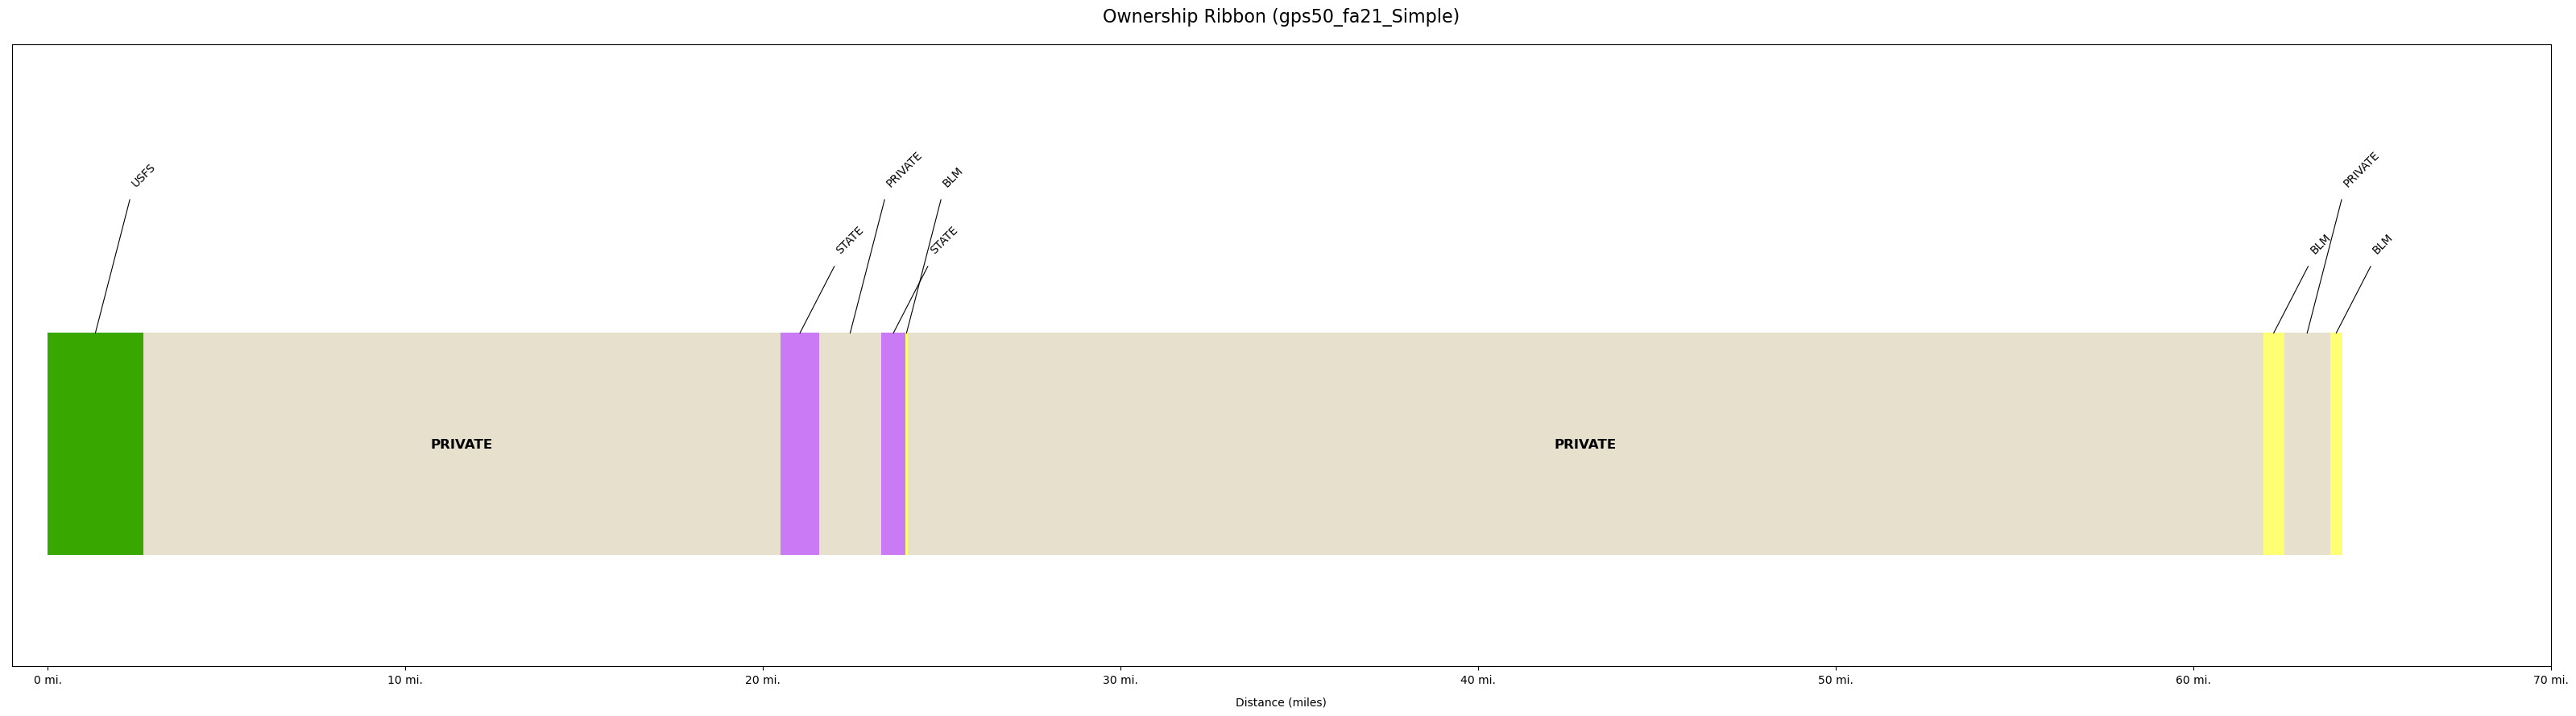

In [ ]:
# Store output from classify_line
data = result1

# Build a dictionary formatted for ribbon_plot()
# - Flatten out Route_Classification list of dicts into separate lists
route_class = {
    'Name': data['Name'],  # Route name (string)
    'Field': [entry['Field'] for entry in data['Route_Classification']],   # Land class labels
    'Length': [entry['Length'] for entry in data['Route_Classification']], # Segment lengths (miles)
    'Route_Index': [entry['Route_Index'] for entry in data['Route_Classification']] # Sequential index
}

# Generate ownership ribbon plot
# - Saves as SVG if save=True
# - Displays interactively if save=False
ribbon_plot(route_class, route_class['Name'], True)

# Elevation plot (currently disabled / not implemented)
# Uncomment when plot_elevation is available
# plot_elevation(data, data['Name'], True)
